In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import pandas as pd
import datetime
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score

In [ ]:
# from sklift.preprocess import balancer,base
# from sklift.models import ClassTransformation, SoloModel
# from sklift.metrics import uplift_at_k, uplift_curve

# X_balance, treat_balance, y_balance = balancer(
#     X_train, treat_train, y_train, verbose=False, random_state=68
# )

In [3]:
features = pd.read_pickle('features_all_30-01.pkl')

In [4]:
features.first_issue_date = features.first_issue_date.astype(int) // 10 ** 9

In [5]:
features.first_redeem_date = features.first_redeem_date.astype(int) // 10 ** 9

In [7]:
cat_features = ['level_1', 'level_2', 'level_3', 'level_4', 'store_id', 'product_id', 'segment_id', 'brand_id', 'vendor_id', 'gender', 'one_time_only']

from sklearn.preprocessing import LabelEncoder
for cat in cat_features:
    c = LabelEncoder()
    c.fit(features[cat])
    features[cat] = c.transform(features[cat])

In [8]:
df_train = pd.read_csv('data/uplift_train.csv', index_col='client_id')
df_test = pd.read_csv('data/uplift_test.csv', index_col='client_id')

In [9]:
from sklearn.model_selection import train_test_split

indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(indices_train, test_size=0.3, random_state=118)

In [34]:
df_features = features.drop(columns=['max_bill', 'min_bill', 'netto'])
# df_features = df_features[['first_issue_date', 'first_redeem_date', 'age','time_delta','store_id', 'netto_log', 'time_delta', 'total_trans_count']]
X_train = df_features.loc[indices_learn, :]
y_train = df_train.loc[indices_learn, 'new_t']
treat_train = df_train.loc[indices_learn, 'treatment_flg']

X_val = df_features.loc[indices_valid, :]
y_val = df_train.loc[indices_valid, 'new_t']
y_val_target = df_train.loc[indices_valid, 'target']
treat_val =  df_train.loc[indices_valid, 'treatment_flg']

In [35]:
train = lgb.Dataset(X_train, y_train,  categorical_feature=cat_features, free_raw_data=False)

In [36]:
val = lgb.Dataset(X_val, y_val, categorical_feature=cat_features, free_raw_data=False)

In [ ]:
#     'boosting_type': 'gbdt',
#     'max_depth':3,
#     'n_jobs':90,
#     'learning_rate':0.5,
#     'num_iterations':30,
#     'reg_alpha':0.001,
#     'reg_lambda':0.001,
#     'num_leaves':7,
# #     'min_data_in_leaf':50000,
# #     'min_child_samples':3,
# #     'min_split_gain':0.5,
# #     'bagging_freq':3,
#     'subsample':0.7,
#     'application':'binary',
#     'metric':'binary_logloss',
# #     'scale_pos_weight':0.97
# #     'pos_bagging_fraction':0.02,
# #     'neg_bagging_fraction':0.98
# #     'feature_fraction': 0.9

In [37]:
params = {
    'boosting_type': 'gbdt',
    'max_depth':4,
    'n_jobs':90,
    'learning_rate':0.01,
    'num_iterations':500,
    'reg_alpha':0.001,
    'reg_lambda':0.001,
    'num_leaves':10,
    'min_data_in_leaf':100,
    'bagging_freq':5,
    'subsample':0.8,
    'application':'multiclass',
    'num_class':4,
    'metric':'multi_logloss',
    'feature_fraction': 0.5
}

clf = lgb.train(
    params,
    train,
    valid_sets=[val],
    feature_name=list(df_features.columns),
    categorical_feature=cat_features,
    early_stopping_rounds=10,
    verbose_eval=50
)

/home/pfedorov/env/lib/python3.6/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds
[50]	valid_0's multi_logloss: 1.3113
[100]	valid_0's multi_logloss: 1.28462
[150]	valid_0's multi_logloss: 1.26878
[200]	valid_0's multi_logloss: 1.25847
[250]	valid_0's multi_logloss: 1.25174
[300]	valid_0's multi_logloss: 1.24744
[350]	valid_0's multi_logloss: 1.24488
[400]	valid_0's multi_logloss: 1.24329
[450]	valid_0's multi_logloss: 1.24224
[500]	valid_0's multi_logloss: 1.24138
Did not meet early stopping. Best iteration is:
[500]	valid_0's multi_logloss: 1.24138


In [38]:
uplift_score(
    clf.predict(X_val)[:, 2]  + clf.predict(X_val)[:, 3] - clf.predict(X_val)[:, 1] - clf.predict(X_val)[:, 0], treat_val, y_val_target)

0.05135487189973076

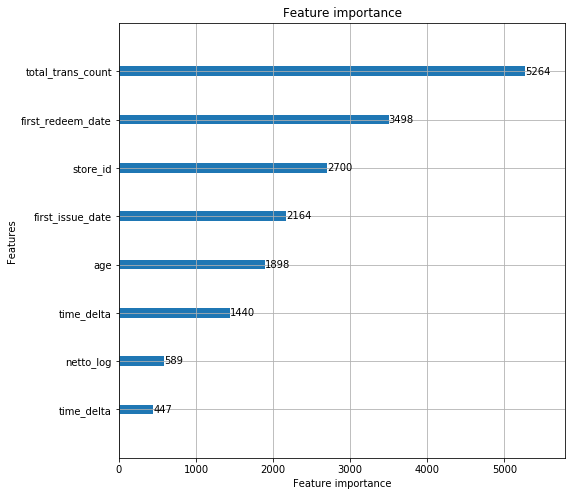

In [17]:
lgb.plot_importance(clf, figsize=(8,8))

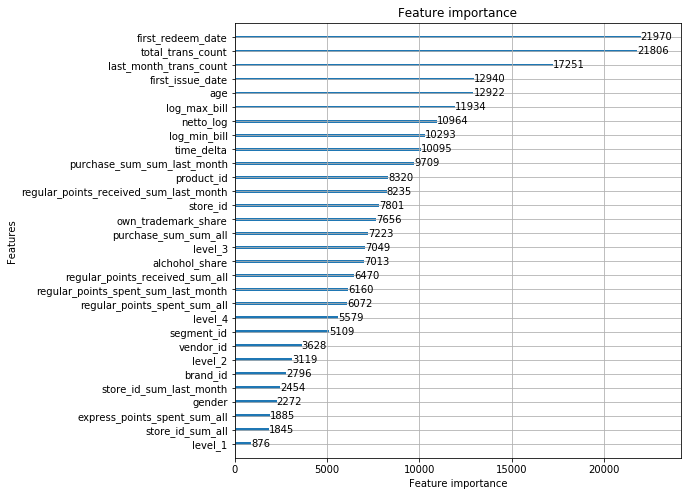

In [65]:
lgb.plot_importance(clf, figsize=(8,8))

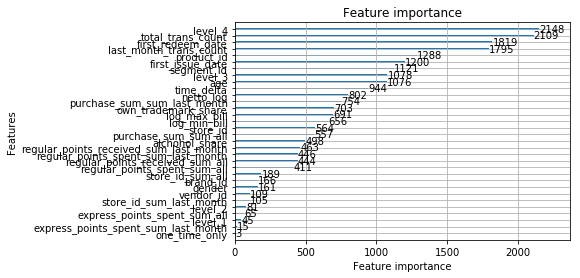

In [52]:
lgb.plot_importance(clf)

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'max_depth':7,
    'n_jobs':90,
    'learning_rate':0.01,
    'num_iterations':500,
    'reg_alpha':0.001,
    'reg_lambda':0.001,
    'num_leaves':100,
    'min_data_in_leaf':100,
    'bagging_freq':5,
    'subsample':0.8,
    'application':'binary',
    'metric':'binary_logloss',
    'feature_fraction': 0.9
}

clf = lgb.train(
    params,
    train,
    valid_sets=[val],
    feature_name=list(df_features.columns),
    categorical_feature=cat_features,
    early_stopping_rounds=10,
    verbose_eval=50
)